In [100]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

In [101]:
DF = pd.read_csv("SPY.csv")
DF.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,26.299288,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,26.486324,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,26.542448,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.822998,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.935240,531500


## Data preprocessing

### Feature Augumentation

In [102]:
def featureAug(df):
    dt = pd.to_datetime(df["Date"])
    Y = []
    M = []
    date = []
    day = []
    for i in range(len(dt)):
        Y.append(dt[i].year)
        M.append(dt[i].month)
        date.append(dt[i].day)
        day.append(dt[i].weekday())
    df['Year'] = Y
    df['Month'] = M
    df['date'] = date
    df['Day'] = day 
    return df

In [229]:
DF_aug = featureAug(DF)
DF_aug.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,date,Day
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,26.299288,1003200,1993,1,29,4
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,26.486324,480500,1993,2,1,0
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,26.542448,201300,1993,2,2,1
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.822998,529400,1993,2,3,2
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.935240,531500,1993,2,4,3


### Normalization

In [230]:
def normalize(df):
    df = df.drop(["Date"], axis=1)
    df_norm = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return df_norm

In [231]:
DF_re = normalize(DF_aug)
DF_re.head()

,Open,High,Low,Close,Adj Close,Volume,Year,Month,date,Day
0,-0.322916,-0.324495,-0.320323,-0.322485,-0.284866,-0.096167,-0.489081,-0.500655,0.442294,0.494903
1,-0.322916,-0.323543,-0.319580,-0.321425,-0.284264,-0.096767,-0.489081,-0.409746,-0.491039,-0.505097
2,-0.322067,-0.323120,-0.319050,-0.321108,-0.284083,-0.097088,-0.489081,-0.409746,-0.457706,-0.255097
3,-0.321430,-0.321534,-0.318202,-0.319518,-0.283179,-0.096711,-0.489081,-0.409746,-0.424373,-0.005097
4,-0.319520,-0.320689,-0.317884,-0.318882,-0.282817,-0.096709,-0.489081,-0.409746,-0.391039,0.244903


In [232]:
len(DF_re)

6867

### Simple Moving Average for 30 days

In [233]:
def MovingAvg(df, size):
    i = 0
    moving_avg = []
    while i < len(df)-size+1:
        this_size = df[i:i+size]
        avg = sum(this_size)/size
        moving_avg.append(avg)
        i += 1
    return moving_avg

In [234]:
DF_rrr = DF_re.drop([i for i in range(29)])
DF_rrr = DF_rrr.reset_index()

In [235]:
SMA30 = MovingAvg(DF_re['Close'], 30)
DF_rre = DF_re[29:].reset_index()
DF_rre['SMA30'] = SMA30

In [333]:
print("Data processed:", len(DF_rre))
DF_rre.head()

Data processed: 6838


,index,Open,High,Low,Close,Adj Close,Volume,Year,Month,date,Day,SMA30
0,29,-0.318777,-0.320266,-0.316717,-0.318565,-0.282636,-0.096580,-0.489081,-0.318837,-0.124373,0.494903,-0.320338
1,30,-0.319201,-0.319948,-0.315869,-0.317823,-0.282214,-0.096962,-0.489081,-0.318837,-0.024373,-0.505097,-0.320182
2,31,-0.318352,-0.319525,-0.315020,-0.317823,-0.282214,-0.097284,-0.489081,-0.318837,0.008961,-0.255097,-0.320062
3,32,-0.318565,-0.320160,-0.316187,-0.318776,-0.282757,-0.097294,-0.489081,-0.318837,0.042294,-0.005097,-0.319984
4,33,-0.318671,-0.319314,-0.315338,-0.317823,-0.282214,-0.097251,-0.489081,-0.318837,0.075627,0.244903,-0.319928


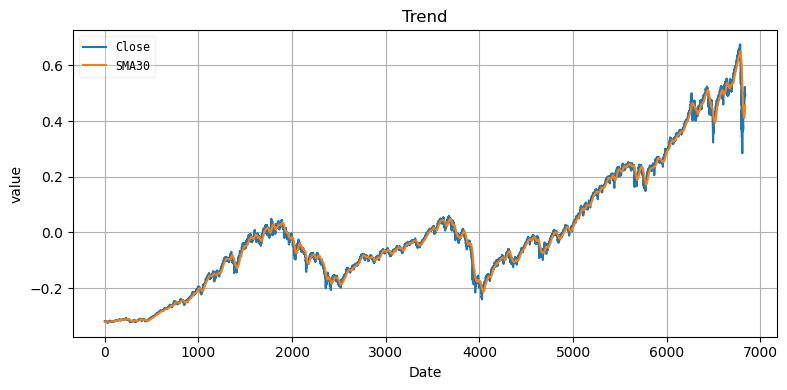

In [337]:
figure, ax = plt.subplots()
plt.plot(DF_rre['Close'], label='Close')
plt.plot(DF_rre['SMA30'], label='SMA30')
figure.set_size_inches(8, 4)
ax.legend(('Close', 'SMA30'), loc='best', framealpha=0.25, prop={'size': 'small', 'family': 'monospace'})

ax.set_title('Trend')
ax.set_xlabel('Date')
ax.set_ylabel('value')

ax.grid(True)
figure.tight_layout()

In [326]:
k = np.array(DF_re.iloc[0:30])

In [239]:
k.shape

(30, 10)

### Using the past 30 days as features to predict the T+29 SMA

#### Features within 30 days include: Open, High, Low, Close, Adj Close, Volume, Year, Month, date, and Day

In [240]:
DF_re.shape

(6867, 10)

In [241]:
DF_rre.shape

(6838, 12)

In [242]:
X = []
Y = []
for i in range(len(DF_rre)-29):
    idx = DF_rre['index'][i]
    X.append(np.array(DF_re.iloc[idx-29:idx+1]))
    Y.append(DF_rre['SMA30'][i+29])
X = np.array(X)
Y = np.expand_dims(Y, axis=1)
print("Input dim:", X.shape)
print("Output dim:", Y.shape)

Input dim: (6809, 30, 10)
Output dim: (6809, 1)


### Split Data

In [243]:
def split(X, Y, rate):
    total = X.shape[0]
    X_train_val = X[:int(round(total*rate))]
    Y_train_val = Y[:int(round(total*rate))]
    last = total - int(round(total*rate))
    X_test = X[-last:]
    Y_test = Y[-last:]
    return X_train_val, Y_train_val, X_test, Y_test

In [244]:
X_train_val, Y_train_val, X_test, Y_test = split(X,Y,0.85) ## training set 70%, validation set 15%, test set 15%
X_train, Y_train, X_val, Y_val = split(X_train_val, Y_train_val, 0.7) # Split a portion as validation set
#Y_train = Y_train[:,:,np.newaxis]
#Y_val = Y_val[:,:,np.newaxis]

In [245]:
X_train.shape, Y_train.shape

((4052, 30, 10), (4052, 1))

## Build Model

In [288]:
def LSTM_seq(shape):
    model = Sequential()
    model.add(LSTM(units=20, return_sequences=False, input_shape=(shape[1], shape[2])))
    model.add(Dropout(0.2))
        
    # output shape: (1, 1)
    model.add(Dense(units=1))
    
    model.compile(loss="mse", optimizer="adam", metrics=['mse'])
    model.summary()
    return model

In [289]:
model = LSTM_seq(X_train.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 20)                2480      
_________________________________________________________________
dropout_16 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 21        
Total params: 2,501
Trainable params: 2,501
Non-trainable params: 0
_________________________________________________________________


## Start training

In [290]:
# Hyperparameters
epoch = 100
batch_size = 64 
early_stopping = EarlyStopping(monitor="loss", patience=10, verbose=2, mode="auto")

In [291]:
log = model.fit(X_train, Y_train, epochs=epoch, batch_size=batch_size, 
                validation_data=(X_val,Y_val),shuffle=False,
                callbacks=[early_stopping])

Train on 4052 samples, validate on 1736 samples
Epoch 1/100
4052/4052 [==============================] - 3s 731us/step - loss: 0.0580 - mean_squared_error: 0.0580 - val_loss: 0.0303 - val_mean_squared_error: 0.0303
Epoch 2/100
4052/4052 [==============================] - 1s 362us/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0158 - val_mean_squared_error: 0.0158
Epoch 3/100
4052/4052 [==============================] - 1s 363us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 4/100
4052/4052 [==============================] - 1s 363us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 5/100
4052/4052 [==============================] - 1s 363us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 6/100
4052/4052 [==============================] - 1s 364us/step - loss: 0.0022 - mean_squared_error: 0.0022 - 

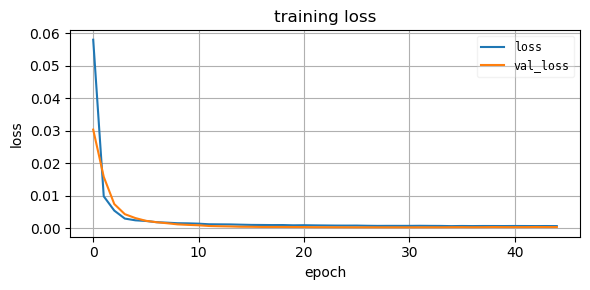

In [336]:
figure, ax = plt.subplots()
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
figure.set_size_inches(6, 3)
ax.legend(('loss', 'val_loss'), loc='best', framealpha=0.25, prop={'size': 'small', 'family': 'monospace'})

ax.set_title('training loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

ax.grid(True)
figure.tight_layout()

In [296]:
model.save('LSTM_stock.h5')  

## Testing & Evaluation

In [309]:
Y_predict = model.predict(X_test)
test_loss = model.evaluate(X_test, Y_test)

1021/1021 [==============================] - 0s 232us/step


In [312]:
print("Mean Square error:", test_loss[0])

Mean Square error: 0.00226554930065079


## Visaulization the results

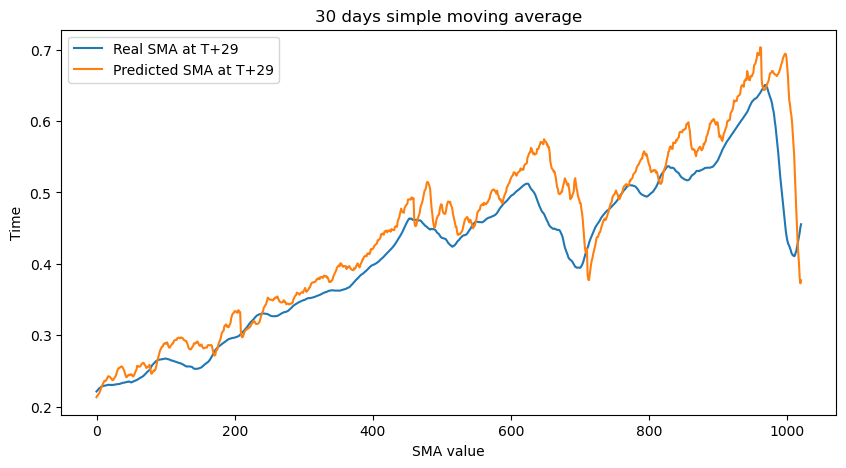

In [329]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
plt.plot(Y_test, label = 'Real SMA at T+29') 
plt.plot(Y_predict, label = 'Predicted SMA at T+29')
plt.title('30 days simple moving average')
plt.xlabel('SMA value')
plt.ylabel('Time')
plt.legend()
plt.show()